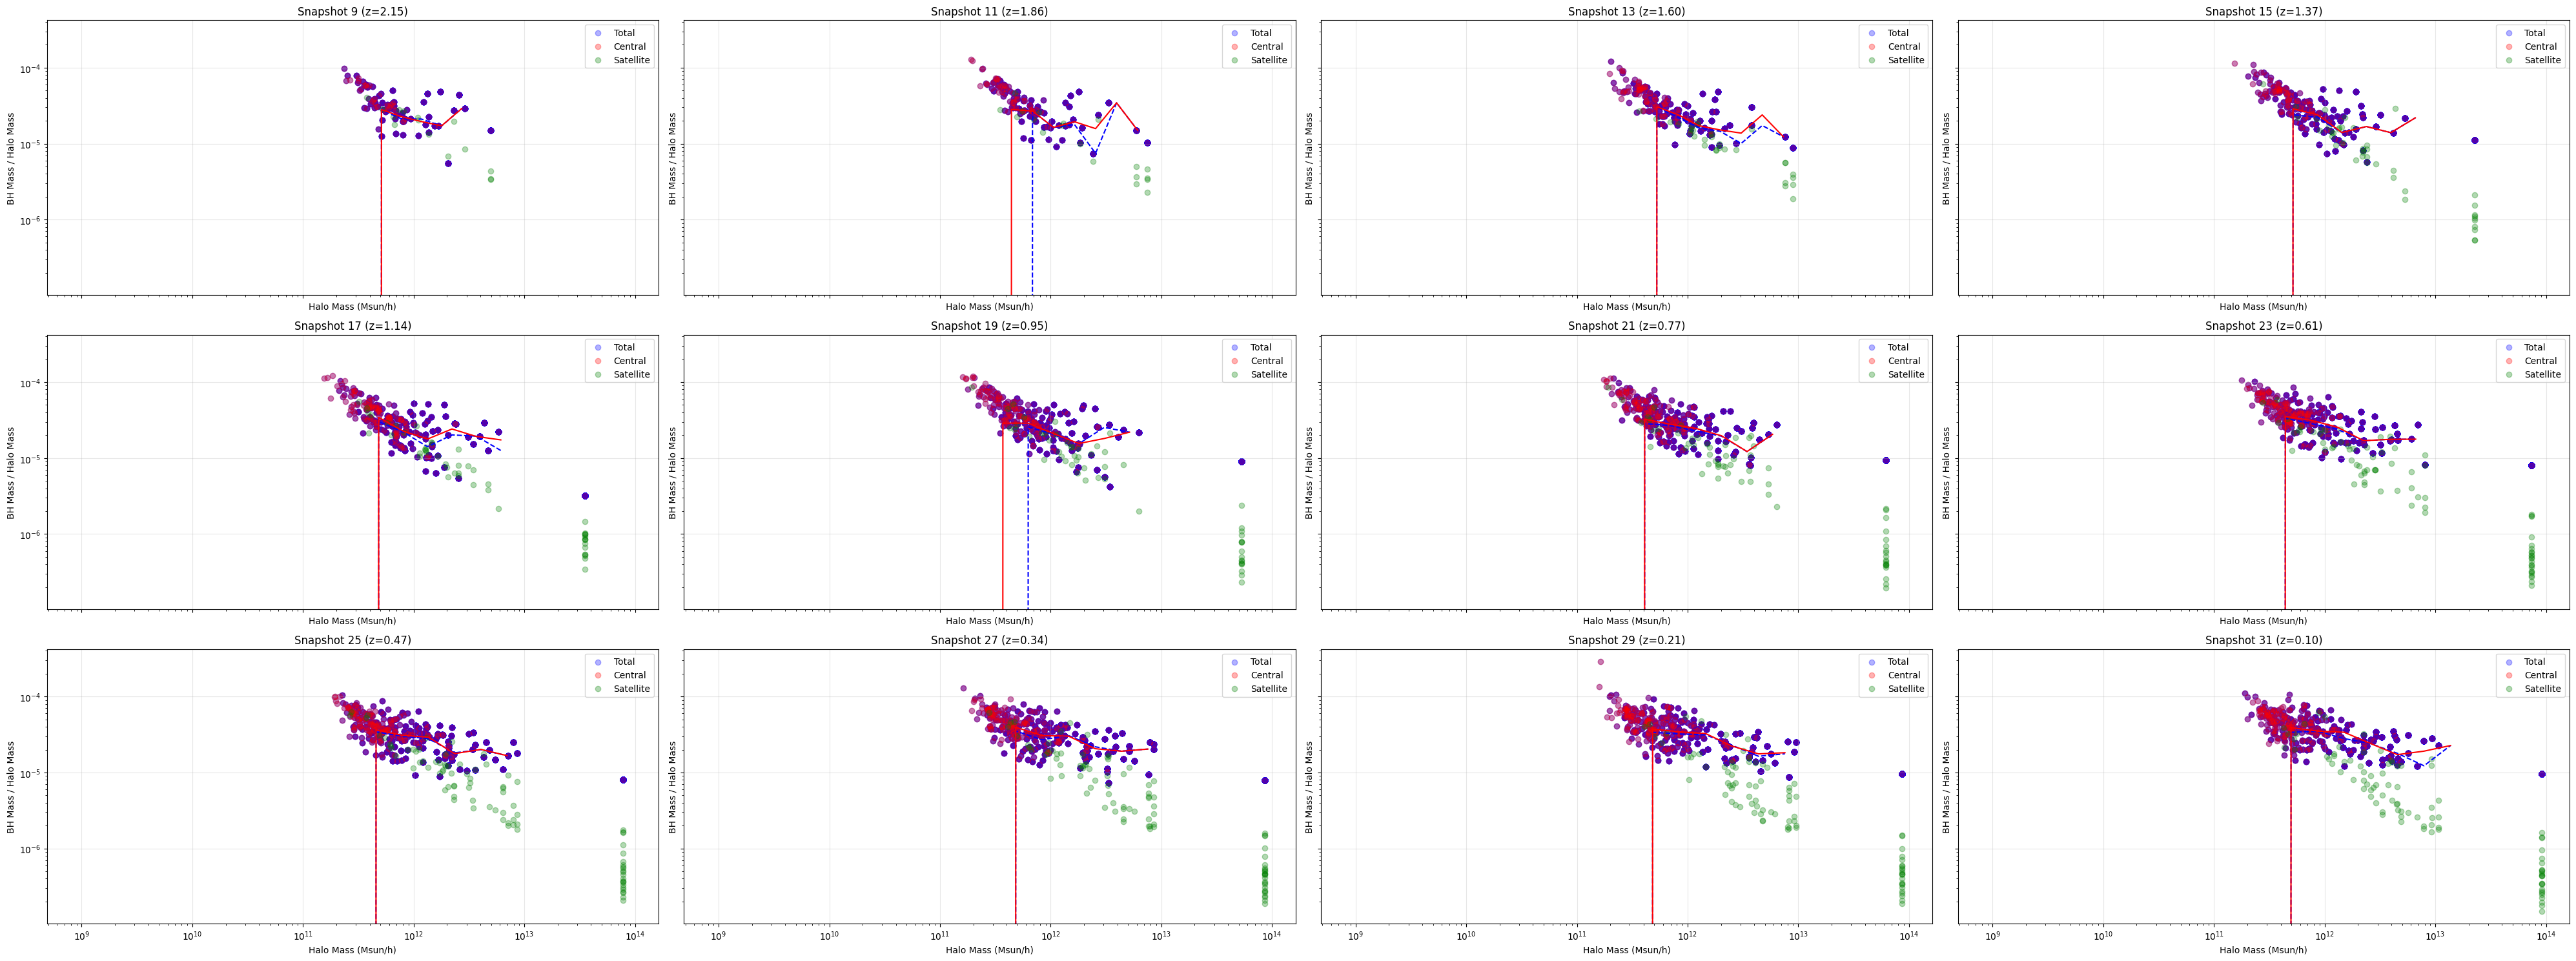

In [34]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def bin_data_with_mask(x, y, num_bins=20):
    bins = np.geomspace(np.min(x), np.max(x), num_bins + 1)
    bin_indices = np.digitize(x, bins) - 1
    bin_averages = [np.median(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(num_bins)]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers, np.array(bin_averages), x, y

def snapshot_graph_bh(): 
    num_snapshots = 12
    num_cols = 4
    num_rows = 3  
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 5 * num_rows), sharex=True, sharey=True)  
    
    plot_count = 0
    skipped_groups = 0
    total_groups = 0
    
    for i in range(9, 33, 2):
        bh_masses = []
        central_masses = []
        satellite_masses = []
        
        central_halo_masses = []
        sat_halo_masses = []
        all_halo_masses = []
        
        result = f"{i:03d}"
        file_path = f"./SimbaTNG-production/bondi_dbug_corrected/snap_{result}.hdf5"
        f_catalog = f"./SimbaTNG-production/bondi_dbug_corrected/fof_subhalo_tab_{result}.hdf5"

        try:
            with h5py.File(file_path, "r") as data, h5py.File(f_catalog, 'r') as f:
                redshift = data["Header"].attrs["Redshift"]
                
                group_first_sub = f['Group/GroupFirstSub'][:]  # First subhalo index (central)
                subhalo_group_nr = f['Subhalo/SubhaloGroupNr'][:]
                halo_masses = f['Group/GroupMass'][:] * 1e10  # Convert to Msun/h
                subhalo_bh_masses = f["Subhalo/SubhaloMassType"][:, 5] * 1e10  # BH mass
                
                for subgroup_idx, parant_idx in enumerate(subhalo_group_nr):
                    total_groups += 1

                    parant_halo_mass = halo_masses[parant_idx]
                    
                    host_halo_central = group_first_sub[parant_idx]

                    if host_halo_central == subgroup_idx:
                        central_mass = subhalo_bh_masses[subgroup_idx]
                        bh_masses.append(central_mass)
                        central_masses.append(central_mass)
                        central_halo_masses.append(parant_halo_mass)
                        all_halo_masses.append(parant_halo_mass)
                        
                    else:
                        satellite_mass = subhalo_bh_masses[subgroup_idx]
                        bh_masses.append(central_mass)
                        satellite_masses.append(satellite_mass)
                        sat_halo_masses.append(parant_halo_mass)
                        all_halo_masses.append(parant_halo_mass)
                
        except FileNotFoundError:
            print(f"Snapshot file {file_path} or catalog {f_catalog} not found. Skipping...")
            continue
        
        array_halo_masses = np.array(all_halo_masses)        
        central_masses = np.array(central_masses)
        satellite_masses = np.array(satellite_masses)
        central_halo_masses = np.array(central_halo_masses)
        sat_halo_masses = np.array(sat_halo_masses)

        # mass ratios
        ratio_central = central_masses / central_halo_masses
        ratio_satellite = satellite_masses / sat_halo_masses
        ratio_total = bh_masses / array_halo_masses
        
        # bin data
        binned_x_all, bin_averages_all, rawXall, rawYAll = bin_data_with_mask(array_halo_masses, ratio_total)
        binned_x_central, bin_averages_central, _, _ = bin_data_with_mask(central_halo_masses, ratio_central)
        binned_x_satellite, bin_averages_satellite, _, _ = bin_data_with_mask(sat_halo_masses, ratio_satellite)

        # plots
        ax = axs[plot_count // num_cols, plot_count % num_cols]
        ax.scatter(rawXall, rawYAll, color="blue", alpha=0.3, label="Total")
        ax.plot(binned_x_all, bin_averages_all, color="blue", linestyle="--")

        ax.scatter(central_halo_masses, ratio_central, color="red", alpha=0.3, label="Central")
        ax.plot(binned_x_central, bin_averages_central, color="red", linestyle="-")

        ax.scatter(sat_halo_masses, ratio_satellite, color="green", alpha=0.3, label="Satellite")
        ax.plot(binned_x_satellite, bin_averages_satellite, color="green", linestyle="-.")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Halo Mass (Msun/h)")
        ax.set_ylabel("BH Mass / Halo Mass")
        ax.set_title(f"Snapshot {i} (z={redshift:.2f})")
        ax.grid(alpha=0.3)
        ax.legend()

        plot_count += 1

    plt.tight_layout()
    plt.show()

snapshot_graph_bh()